# Kernel methods for a 1 dimensional elliptic PDE

Here we will solve the PDE

$$\begin{cases} C_1 u^3 + C_2 \Delta u = f, & \boldsymbol{x} \in [0,1]^d \\ u = 0, &\boldsymbol{x} \in \partial [0,1]^d \end{cases}$$

where $\Delta$ is the Laplacian.

In [1]:
import qmcpy as qp 
import numpy as np 
import torch
import time
from collections import OrderedDict

In [2]:
# plotting setup
from matplotlib import pyplot,cm,colors,gridspec
pyplot.style.use('seaborn-v0_8-whitegrid')
LW = 3

## Reference Solution

We will take the true solution to be 

$$u(x) = \exp\left(-\frac{1}{1-r^2}\right)\left[\sin(\pi x)+\frac{1}{2}\sin(4\pi x)\right] 1_{x \in (0,1)}$$

where $r = 2x-1$.

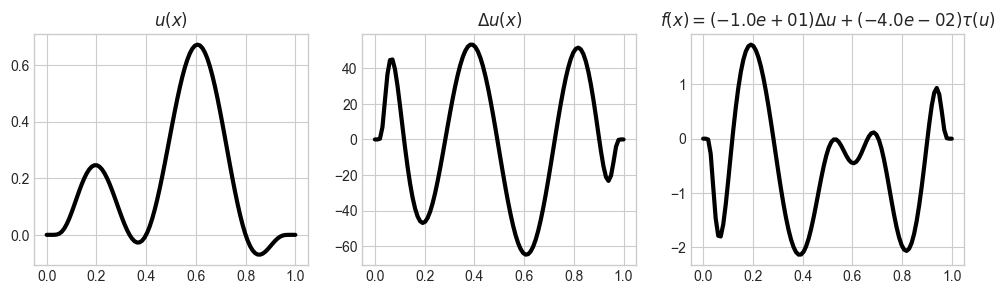

In [3]:
C1 = -10
C2 = -1/25 
def u(x):
    y = torch.zeros_like(x)
    r = 2*x-1
    b = torch.abs(r)<1
    t1 = torch.exp(-1/(1-r[b]**2))
    t2 = torch.sin(torch.pi*x[b])
    t3 = torch.sin(4*torch.pi*x[b])
    y[b] = t1*(t2+t3)
    return y
def u_laplace(x):
    xg = x.clone().requires_grad_()
    yg = u(xg)
    grad_outputs = torch.ones_like(x)
    ypg = torch.autograd.grad(yg,xg,grad_outputs,create_graph=True)[0]
    yppg = torch.autograd.grad(ypg,xg,grad_outputs,create_graph=True)[0]
    return yppg.detach()
def f(x):
    return C1*u(x)**3+C2*u_laplace(x)
xticks = torch.linspace(0,1,100,dtype=float)
yticks = u(xticks) 
ylticks = u_laplace(xticks)
fticks = f(xticks)
fig,ax = pyplot.subplots(nrows=1,ncols=3,figsize=(12,3))
ax[0].plot(xticks,yticks,color='k',linewidth=LW)
ax[1].plot(xticks,ylticks,color='k',linewidth=LW)
ax[2].plot(xticks,fticks,color='k',linewidth=LW)
# ax[2].plot(xticks,-u_laplace_1d(xticks))
# ax[2].plot(xticks,tau_1d(u_1d(xticks)))
ax[0].set_title(r"$u(x)$")
ax[1].set_title(r"$\Delta u(x)$")
ax[2].set_title(r"$f(x) = (%.1e) \Delta u + (%.1e) \tau(u)$"%(C1,C2));

## PDE Setup

Recall the PDE is 

$$\begin{cases} C_1 \Delta u + C_2 u^3 = f, & \boldsymbol{x} \in [0,1]^d \\ u = 0, &\boldsymbol{x} \in \partial [0,1]^d \end{cases}.$$

We will "sample" both $u$ and $\Delta u$ at common collocation points on the interior, and we will  "sample" $u$ at collocation points on the boundary. The boundary collocation points are a projection of the first few interior collocation points. In the **Data Driven** section these samples of will be evaluated from the true solution. In the **Physics Informed** section these samples will be optimized to minimize the kernel interpolant norm while satisfying the PDE equatioins.

In [4]:
d = 1 
noise = 1e-8

In [5]:
us = torch.tensor([ # dimensions not projected to the 0 boundary
    [True], # interior points (not projected to the 0 boundary)
    [False] # boundary points (projected to the 0 boundary) 
],dtype=bool) 
llbetas = [ # derivative orders 
    [ # interior
        torch.tensor([[0]],dtype=int), # u
        torch.tensor([[2]],dtype=int)], # laplacian u d^2u/(dx)^2 
    [ # boundary
        torch.tensor([[0]],dtype=int) # u
    ]
]
llcs = [ # summand of derivatives coefficients
    [ # interior
        torch.ones(1,dtype=float), # 1*u 
        torch.ones(1,dtype=float) # laplacian 1*d^2u/(dx)^2
    ],
    [
        torch.ones(1,dtype=float) # 1*u
    ]
]

## Kernel Interpolant Initialization

All kernel interpolants will use lattice collocation points

In [6]:
lattice = qp.Lattice(d,seed=7)

### GaussKI: Gaussian Kernel with Lattice Points

In [7]:
ns_gauss = torch.tensor([ # number of collocation points
    2**12, #  on the interior
    2 # on the boundary
],dtype=int)
kernel_gauss = qp.KernelGaussian(d,lengthscales=.1,scale=1.,torchify=True)

In [8]:
t0_gauss = time.perf_counter()
ki_gauss = qp.PDEGramMatrix(lattice,kernel_gauss,ns=ns_gauss,us=us,llbetas=llbetas,llcs=llcs,noise=noise)
time_gauss = time.perf_counter()-t0_gauss
print("time_gauss = %.1e"%time_gauss)

time_gauss = 1.3e+01


### SIKI: Shift-Invariant Kernel with Lattice Points 

Since shift-invariant kernels are periodic (with smoothness $\alpha$), we only need $1$ boundary point.

In [9]:
ns_si = torch.tensor([ # number of collocation points
    2**12, #  on the interior
    1 # on the boundary
],dtype=int)
kernel_si = qp.KernelShiftInvar(d,lengthscales=1.,alpha=4,scale=1.,torchify=True)

In [10]:
t0_si = time.perf_counter()
ki_si = qp.PDEGramMatrix(lattice,kernel_si,ns=ns_si,us=us,llbetas=llbetas,llcs=llcs,noise=noise)
time_si = time.perf_counter()-t0_si
print("time_si = %.1e"%time_si)

time_si = 4.3e+00


### Fast SIKI: Fast Shift-Invariant Kernel with Lattice Points

When a shift-invariant kernel is paired with lattice points, the Gram matrix is nicely structured with circulant-like matrices. This is exploited to reduced memory and speed up computations with the Gram matrix.

In [11]:
t0_si_fast = time.perf_counter()
ki_si_fast = qp.FastPDEGramMatrix(lattice,kernel_si,ns=ns_si,us=us,llbetas=llbetas,llcs=llcs,noise=noise)
time_si_fast = time.perf_counter()-t0_si_fast
print("time_si_fast = %.1e"%time_si_fast)

time_si_fast = 5.3e-02


## Data Driven Kernel Interpolant

First, let's assume the "samples" of terms appearing the PDE at the given colloation points are  available. This is only possible because we have perscribed the PDE solution to this toy problem. Later in the **Physics Informed** section we will learn these "samples". 

### Coefficients

#### Cholesky GaussKI

In [12]:
xs_gauss = ki_gauss.get_xs()
xi_gauss,xb_gauss = xs_gauss[0][:,0],xs_gauss[1][:,0]
print("xi_gauss.shape = %s"%xi_gauss.shape)
print("xb_gauss.shape = %s"%xb_gauss.shape)

xi_gauss.shape = 4096
xb_gauss.shape = 2


In [13]:
yi_gauss = u(xi_gauss)
yil_gauss = u_laplace(xi_gauss)
yb_gauss = u(xb_gauss)
y_gauss = torch.hstack([yi_gauss,yil_gauss,yb_gauss])
print("y_gauss.shape = %s"%y_gauss.shape)

y_gauss.shape = 8194


In [14]:
coeffs_gauss_chol = ki_gauss._solve(y_gauss) # Cholesky solve system in Gram matrix
print("coeffs_gauss_chol.shape = %s"%coeffs_gauss_chol.shape)

coeffs_gauss_chol.shape = 8194


#### Cholesky SIKI 

The following points are used for both SIKI and Fast SIKI

In [15]:
xs_si = ki_si.get_xs()
xi_si,xb_si = xs_si[0][:,0],xs_si[1][:,0]
print("xi_si.shape = %s"%xi_si.shape)
print("xb_si.shape = %s"%xb_si.shape)

xi_si.shape = 4096
xb_si.shape = 1


In [16]:
yi_si = u(xi_si)
yil_si = u_laplace(xi_si)
yb_si = u(xb_si)
y_si = torch.hstack([yi_si,yil_si,yb_si])
print("y_si.shape = %s"%y_si.shape)

y_si.shape = 8193


In [17]:
t0 = time.perf_counter()
coeffs_si_chol = ki_si._solve(y_si)
time_si_chol = time.perf_counter()-t0
print("coeffs_si_chol.shape = %s"%coeffs_si_chol.shape)
print("time_si_chol = %.1e"%time_si_chol)

coeffs_si_chol.shape = 8193
time_si_chol = 1.3e+00


#### PCG SIKI with Incomplete Cholesky

PCG is the Preconditioned Conjugate Gradient Method


In [18]:
t0 = time.perf_counter()
coeffs_si_pcg,rerrors_si_pcg,times_pcg_si_pcg = ki_si.pcg(y_si,precond=True)
time_si_pcg = time.perf_counter()-t0
print("coeffs_si_cg.shape = %s"%coeffs_si_chol.shape)
print("time_si_pcg = %.1e"%time_si_pcg)

coeffs_si_cg.shape = 8193
time_si_pcg = 4.5e+01


In [19]:
print("condition number: %.1e"%torch.linalg.cond(ki_si.gm))
print("condition number after incomplete Chol preconditioning: %.1e"%torch.linalg.cond(ki_si.precond_solve(ki_si.gm)))
print("incomplete Chol precond shape: %s"%str(tuple(ki_si.Lk.shape)))

condition number: 6.4e+14
condition number after incomplete Chol preconditioning: 2.2e+06
incomplete Chol precond shape: (8193, 1006)


#### PCG SIKI with FFT Preconditioner

In [20]:
t0 = time.perf_counter()
coeffs_si_fast_pcg,rerrors_si_fast_pcg,times_si_fast_pcg = ki_si_fast.pcg(y_si,precond=True)
time_si_fast_pcg = time.perf_counter()-t0
print("coeffs_si_fast.shape = %s"%coeffs_si_chol.shape)
print("time_si_fast_pcg = %.1e"%time_si_fast_pcg)

coeffs_si_fast.shape = 8193
time_si_fast_pcg = 2.1e-01


In [21]:
ki_si_fast_gm = ki_si_fast.get_full_gram_matrix()
print("condition number: %.1e"%torch.linalg.cond(ki_si_fast_gm))
print("condition number after incomplete Chol preconditioning: %.1e"%torch.linalg.cond(ki_si_fast.precond_solve(ki_si_fast_gm)))

condition number: 6.4e+14
condition number after incomplete Chol preconditioning: 4.2e+14


#### Comparison

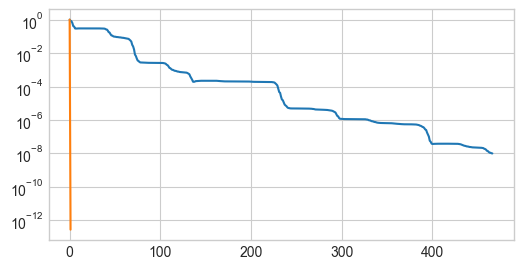

In [22]:
fig,ax = pyplot.subplots(nrows=1,ncols=1,figsize=(6,3))
ax.plot(rerrors_si_pcg)
ax.plot(rerrors_si_fast_pcg)
ax.set_yscale("log",base=10)

### Predictions

In [23]:
kvec_gauss = ki_gauss.get_new_left_full_gram_matrix(xticks[:,None])
fhat_gauss = kvec_gauss@coeffs_gauss_chol
print("fhat_gauss.shape = %s"%fhat_gauss.shape)

fhat_gauss.shape = 100


In [24]:
kvec_si = ki_si.get_new_left_full_gram_matrix(xticks[:,None])
fhat_si = kvec_si@coeffs_si_pcg
print("fhat_si.shape = %s"%fhat_si.shape)

fhat_si.shape = 100


In [25]:
kvec_si_fast = ki_si_fast.get_new_left_full_gram_matrix(xticks[:,None])
fhat_si_fast = kvec_si_fast@coeffs_si_fast_pcg
print("fhat_si_fast.shape = %s"%fhat_si_fast.shape)

fhat_si_fast.shape = 100


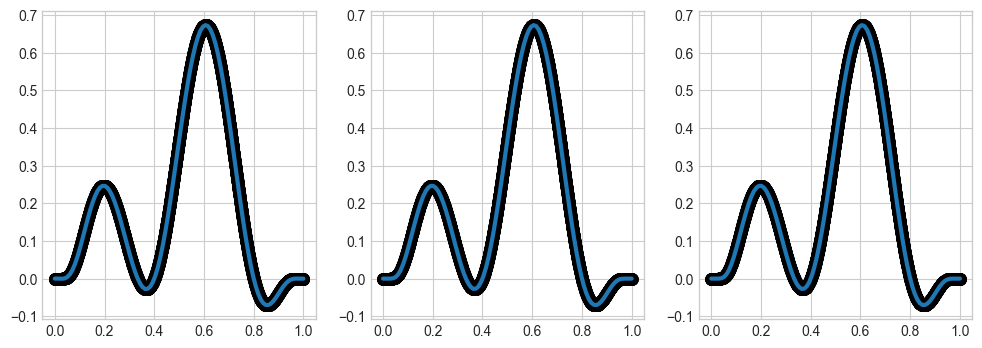

In [26]:
fig,ax = pyplot.subplots(nrows=1,ncols=3,figsize=(12,4))
for i in range(3):
    ax[i].plot(xticks,yticks,color="k",linewidth=LW)
ax[0].scatter(xi_gauss,yi_gauss,color="k",linewidth=LW)
ax[0].scatter(xb_gauss,yb_gauss,color="k",linewidth=LW)
ax[0].plot(xticks,fhat_gauss,linewidth=LW)
for i in range(1,3):
    ax[i].scatter(xi_si,yi_si,color="k",linewidth=LW)
    ax[i].scatter(xb_si,yb_si,color="k",linewidth=LW)
ax[1].plot(xticks,fhat_si,linewidth=LW)
ax[2].plot(xticks,fhat_si_fast,linewidth=LW);